# Predicting the price of a flat given a list of predictors using different regression models such as RandomForestRegressor, XGBRegressor, DecisionTreeRegressor, LGBMRegressor, LinearRegression

In [1]:
# importing required libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import missingno as msno
import json
pd.set_option('display.max_columns', 60)
import pandas_profiling as pf
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
print('Complete')

Complete


In [2]:
# Importing dataset
data = pd.read_json(r'C:\Users\ABDULAZEEZ R.O\Desktop\1\SQL&TABLEAU\amsterdam.json')
data.head()

,host_listings_count,accommodates,bathrooms,bedrooms,guests_included,minimum_nights,number_of_reviews,calculated_host_listings_count,price,latitude,longitude,room_type,instant_bookable
0,1.0,6,1.0,2.0,1,3,4,1,$145.00,52.361173,4.866755,Entire home/apt,f
1,1.0,2,1.0,1.0,1,2,17,1,$88.00,52.370237,4.859507,Entire home/apt,f
10,1.0,2,1.0,1.0,1,3,0,1,$130.00,52.371424,4.848644,Entire home/apt,f
100,1.0,5,1.0,4.0,1,5,2,1,$90.00,52.312889,4.980151,Entire home/apt,f
1000,1.0,1,1.0,1.0,1,1,32,1,$39.00,52.395334,4.916701,Private room,t


In [3]:
# checking the dimension of the data
nrows, ncols = data.shape
print(f'We have {nrows} rows and {ncols} columns')

We have 15181 rows and 13 columns


In [4]:
# statistical description of the data
data.describe()

,host_listings_count,accommodates,bathrooms,bedrooms,guests_included,minimum_nights,number_of_reviews,calculated_host_listings_count,latitude,longitude
count,15178.000000,15181.000000,15163.000000,15169.000000,15181.000000,15181.000000,15181.000000,15181.000000,15181.000000,15181.000000
mean,3.404994,2.917858,1.122832,1.412222,1.516106,2.882551,17.785456,2.934787,52.365353,4.889025
std,11.324173,1.404973,0.356547,0.885127,1.004709,7.215722,34.747999,8.968696,0.015738,0.034901
min,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,52.290308,4.753513
25%,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,52.355616,4.865016
50%,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,7.000000,1.000000,52.365028,4.886344
75%,1.000000,4.000000,1.000000,2.000000,2.000000,3.000000,18.000000,1.000000,52.374829,4.907857
max,106.000000,17.000000,8.000000,10.000000,16.000000,523.000000,496.000000,91.000000,52.426224,5.027689


In [5]:
# checking the information of uor data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15181 entries, 0 to 9999
Data columns (total 13 columns):
host_listings_count               15178 non-null float64
accommodates                      15181 non-null int64
bathrooms                         15163 non-null float64
bedrooms                          15169 non-null float64
guests_included                   15181 non-null int64
minimum_nights                    15181 non-null int64
number_of_reviews                 15181 non-null int64
calculated_host_listings_count    15181 non-null int64
price                             15181 non-null object
latitude                          15181 non-null float64
longitude                         15181 non-null float64
room_type                         15181 non-null object
instant_bookable                  15181 non-null object
dtypes: float64(5), int64(5), object(3)
memory usage: 1.6+ MB


In [12]:
# Increase the speed of our data exploration by using data profiling

#pf.ProfileReport(data) #___Uncomment this line to see the report

As described in the report, the dataset contains 14 variables, 10 are numeric and 2 categorical (we will probably need to get dummy variables for those when modelling).

Moreover, according to the report variable host_listings_count and calculated_host_listings_count are highly correlated with a Pearson score of 0.96, hence we will discard the former to avoid multicollinearity problems.

In [8]:
# selecting object type columns
object_col = data.select_dtypes('object').head()
object_col

,price,room_type,instant_bookable
0,$145.00,Entire home/apt,f
1,$88.00,Entire home/apt,f
10,$130.00,Entire home/apt,f
100,$90.00,Entire home/apt,f
1000,$39.00,Private room,t


In [9]:
# lets check if these columns are mix with strings
object_col.infer_objects().dtypes

price               object
room_type           object
instant_bookable    object
dtype: object

We can see that our target variable price is not a number, let’s have a look to the longest one, in order to understand if there are any formatting applied that needs to be removed before converting

In [10]:
max(data['price'].values, key  = len)

'$1,500.00'

In [11]:
# change the format of price column by removing dollar sign and comma sign
data['price'] = data['price'].str.replace('$', '')
data['price'] = data['price'].str.replace(',', '')

In [12]:
#converting price to float
data['price'] = data['price'].astype('float')
data['price'].dtypes

dtype('float64')

In [14]:
# checking the value in instant_bookable column
data['instant_bookable'].value_counts()

f    12810
t     2371
Name: instant_bookable, dtype: int64

In [13]:
# replacing the value in 'instant_bookable' with their full name
data['instant_bookable'] = data['instant_bookable'].replace({'f':'False', 't': 'True'})
data['instant_bookable'].value_counts()

False    12810
True      2371
Name: instant_bookable, dtype: int64

## Dealing with missing value

In [14]:
data.isnull().values.any()

True

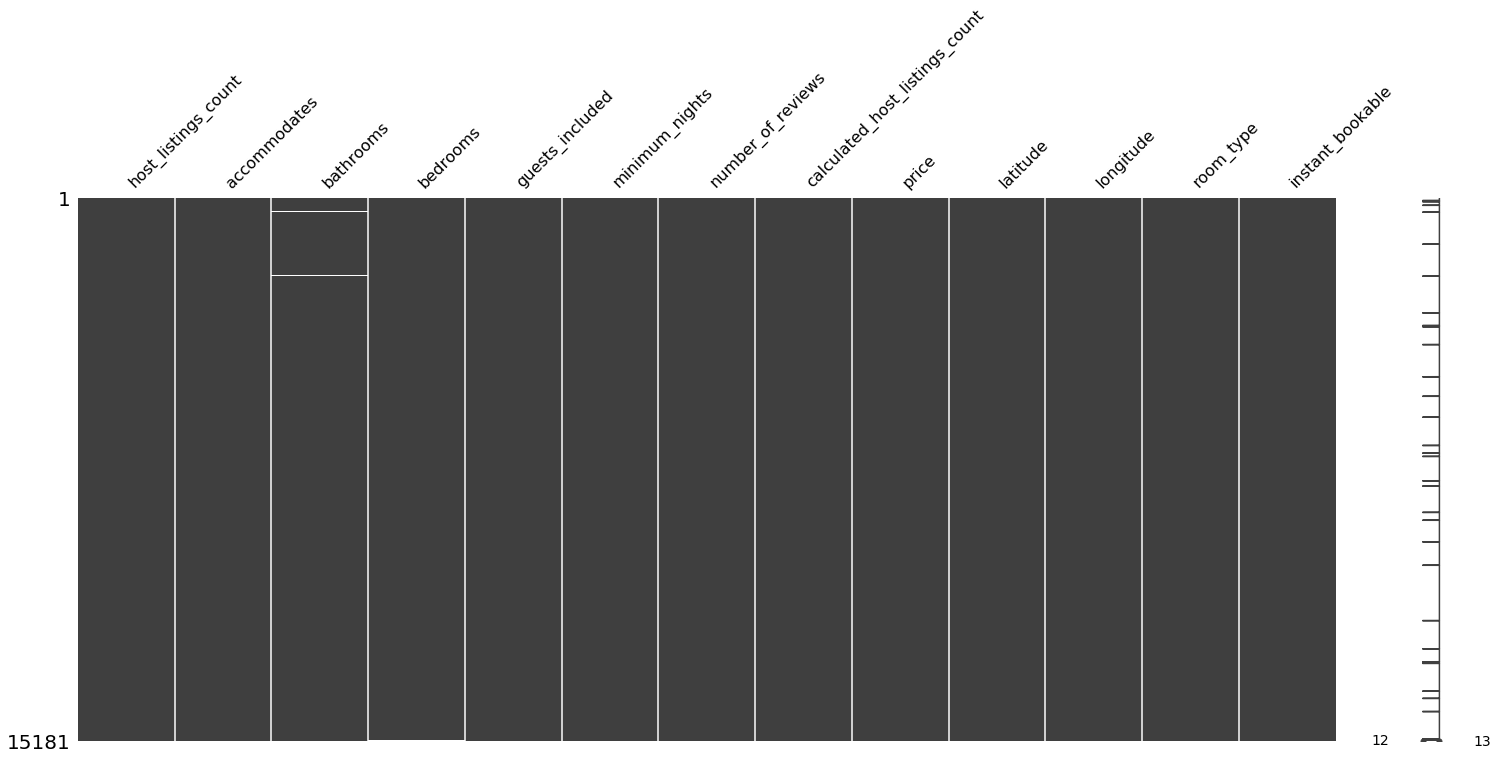

In [16]:
# visualising the missing columns
msno.matrix(data)

In [16]:
nan = data.isnull().sum()
print(nan[nan>0])

host_listings_count     3
bathrooms              18
bedrooms               12
dtype: int64


In [17]:
# checking the percentage of the missing values in respect to their column
total = data.isnull().sum().sort_values(ascending = False)
percent = ((data.isnull().sum()/data.isnull().count())*100).sort_values(ascending = False)
missg = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing = missg[missg['Total'] > 0]
missing

,Total,Percent
bathrooms,18,0.118569
bedrooms,12,0.079046
host_listings_count,3,0.019762


## Data Visualization:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'The price visualization')

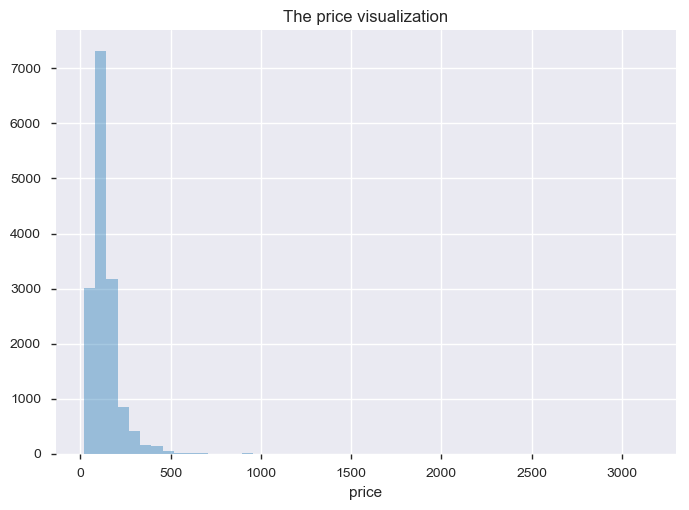

In [19]:
# let's visualize our price movement
sns.distplot(a = data['price'].dropna(), kde = False)
plt.title('The price visualization')

In [20]:
# print out all the unique columns
data.select_dtypes('object').columns

Index(['room_type', 'instant_bookable'], dtype='object')

In [21]:
# checking the values of room_type
data['room_type'].value_counts()

Entire home/apt    11811
Private room        3306
Shared room           64
Name: room_type, dtype: int64

Text(0.5, 1.0, 'The relationship between price and room_type')

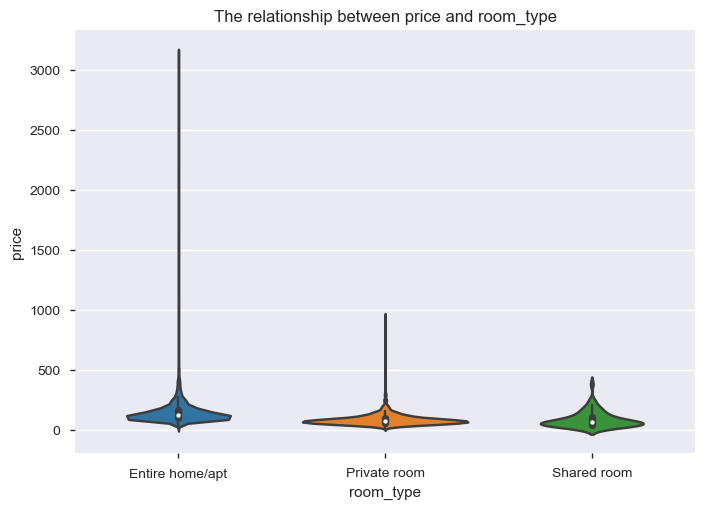

In [22]:
# checking the relationship of room_type to price
sns.violinplot(data['room_type'], data['price'])
plt.title('The relationship between price and room_type')

In [25]:
# checking the values in our instant_bookable
instant_bookable = data['instant_bookable'].value_counts()
instant_bookable

False    12810
True      2371
Name: instant_bookable, dtype: int64

Text(0, 0.5, 'Number of booking')

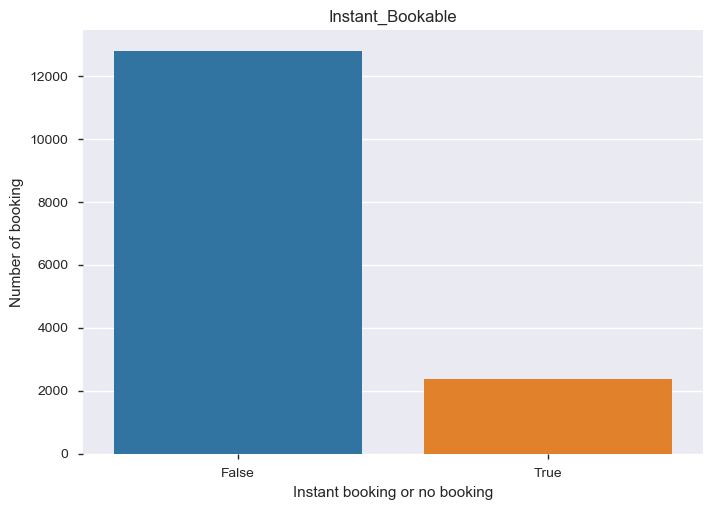

In [26]:
# visualizing the diff between intsant booking and non_instant booking
sns.barplot(instant_bookable.index, instant_bookable.values)
plt.title('Instant_Bookable')
plt.xlabel('Instant booking or no booking')
plt.ylabel('Number of booking')

We can see that we have larger percentage of non instant booking

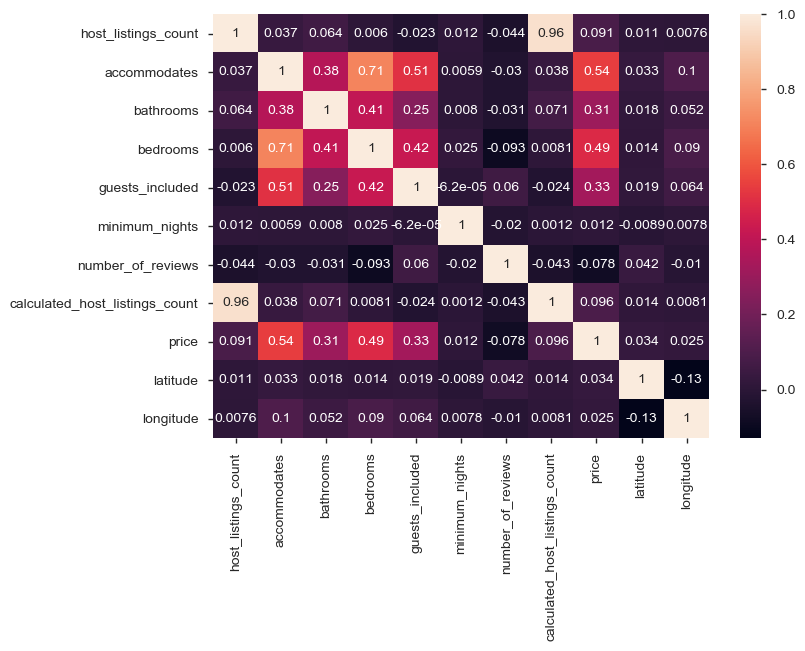

In [27]:
# checking the correlations of all our variables to our target values
corr = data.corr()
sns.heatmap(corr, annot = True)

We can see from the above that the host_listings_count column and Calculated_host_listings_count column are highly correlated, we remove one of these columns to avoid Multicollinearity.

In [32]:
# we are gonna drop 'calculated_host_listings_count' because is higly correlated with other value
data = data.drop(['calculated_host_listings_count'], axis = 1)
data.columns

Index(['host_listings_count', 'accommodates', 'bathrooms', 'bedrooms',
       'guests_included', 'minimum_nights', 'number_of_reviews', 'price',
       'latitude', 'longitude', 'room_type', 'instant_bookable'],
      dtype='object')

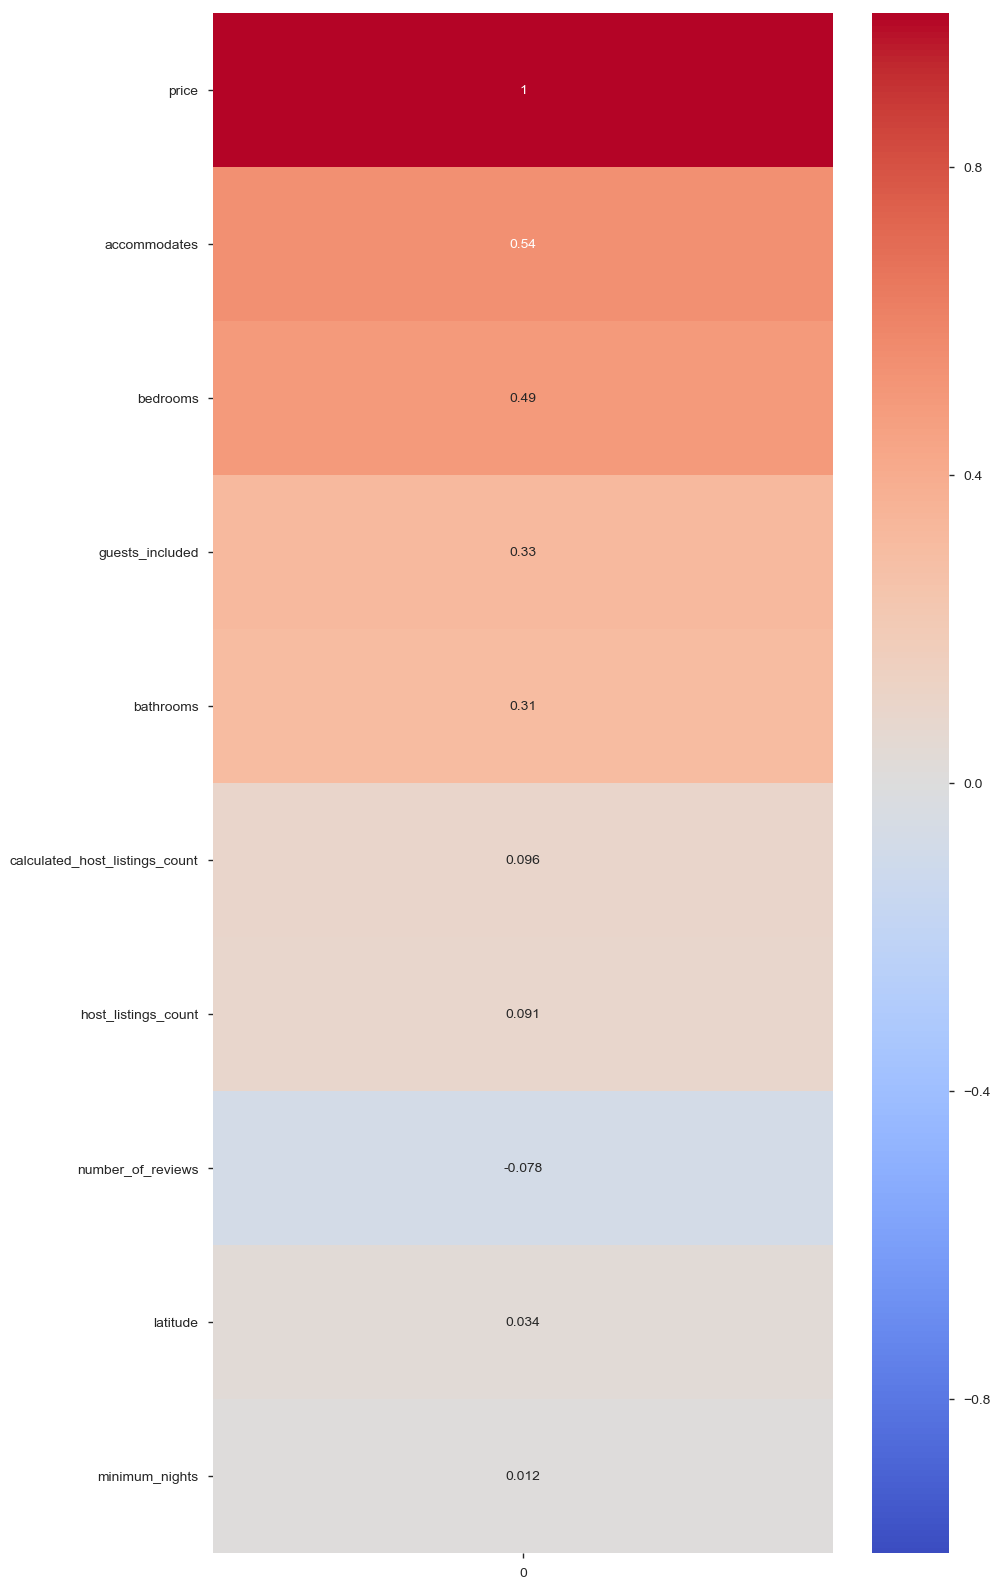

In [29]:
correlations = data.corrwith(data['price']).iloc[:-1].to_frame()
correlations['abs'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('abs', ascending=False)[0]

fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(sorted_correlations.to_frame(), cmap='coolwarm', annot=True, vmin=-1, vmax=1, ax=ax);

In [31]:
#sns.pairplot(data) uncomment this code to see visual relationship of all features

In [42]:
# converting object type to numeric data type by using one_hot encoding or pandas dummy
data = pd.get_dummies(data)
data.head()

,host_listings_count,accommodates,bathrooms,bedrooms,guests_included,minimum_nights,number_of_reviews,price,latitude,longitude,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,instant_bookable_False,instant_bookable_True
0,1.0,6,1.0,2.0,1,3,4,145.0,52.361173,4.866755,1,0,0,1,0
1,1.0,2,1.0,1.0,1,2,17,88.0,52.370237,4.859507,1,0,0,1,0
10,1.0,2,1.0,1.0,1,3,0,130.0,52.371424,4.848644,1,0,0,1,0
100,1.0,5,1.0,4.0,1,5,2,90.0,52.312889,4.980151,1,0,0,1,0
1000,1.0,1,1.0,1.0,1,1,32,39.0,52.395334,4.916701,0,1,0,0,1


## MODELING

In [45]:
# sepersting the target and features variables
y = data.price
x = data.drop(['price'], axis = 1)

In [46]:
# spliting the data to train and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [54]:
# Imputing the missing values with SimpleImputer with the strategy of mean
xtrain = x_train.copy()
xtest = x_test.copy()

# lets impute our missing value with simple imputer
from sklearn.impute import SimpleImputer

#Imputation
imputer = SimpleImputer(strategy = 'mean')
imputed_x_train = pd.DataFrame(imputer.fit_transform(xtrain))
imputed_x_test = pd.DataFrame(imputer.transform(xtest))


# Imputation removed column names; put them back
imputed_x_train.columns = xtrain.columns
imputed_x_test.columns = xtest.columns



### LinearRegression


In [74]:

LR = LinearRegression()
LR.fit(imputed_x_train, y_train)
pred = LR.predict(imputed_x_test
                 )
mae_LR = mean_absolute_error(pred, y_test)
mae_LR

39.02327402047178

## RandomForest

In [75]:
RF = RandomForestRegressor(n_estimators = 100, random_state = 1)
RF.fit(imputed_x_train, y_train)

# prediction
pred = RF.predict(imputed_x_test)

# evaluate our prediction
mae_RF = mean_absolute_error(pred, y_test)
mae_RF

35.24716496542641

We can see that Random Forest model is well perform ccompare to the first model above

## Extreme Gradient Boosting


In [76]:
XGB  = XGBRegressor()
XGB.fit(imputed_x_train, y_train)

# prediction
pred = XGB.predict(imputed_x_test)

# evaluate our prediction
mae_XGB = mean_absolute_error(pred, y_test)
mae_XGB

34.85395064211065

This is really great model compare to Random Forest above

## Decision Tree Regressor


In [77]:
DT  = DecisionTreeRegressor()
DT.fit(imputed_x_train, y_train)

# prediction
pred = DT.predict(imputed_x_test)

# evaluate our prediction
mae_DT = mean_absolute_error(pred, y_test)
mae_DT


46.78827790582812

## LIGHTGBM

In [72]:

LGB = LGBMRegressor()

LGB.fit(imputed_x_train, y_train)

# prediction
pred = LGB.predict(imputed_x_test)

# evaluate our prediction
mae_LGB = mean_absolute_error(pred, y_test)
mae_LGB

33.372013781395836

### visualizing our model

<Figure size 1080x432 with 0 Axes>

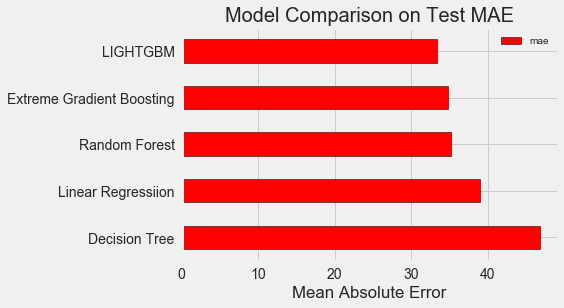

In [82]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (15, 6))

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['LIGHTGBM', 'Decision Tree',
                                           'Random Forest', 'Extreme Gradient Boosting',
                                            'Linear Regressiion'],
                                 'mae': [mae_LGB, mae_DT, mae_RF, mae_XGB, mae_LR]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);






Depending on the run (the exact results change slighty each time), the light gradient boosting regressor performs the best followed by the Extreme Gradient Booting and the random forest. I have to admit that this is not the most fair comparison because we are using mostly the default hyperparameters. The hyperparameters have a significant influence on performance. (the random forest and gradient boosting methods are great for starting out because the performance is less dependent on the model settings). Nonetheless, from these results, we can conclude that machine learning is applicable because all the models significantly perform well!